# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

**Dataset:** Scikit-Learn Diabetes dataset

**Objective:** Build models to predict the disease progression one year after baseline. Models include univariate polynomial regressions (BMI), multivariate polynomial models, Decision Trees, kNNs, and Logistic Regression classifiers (as a screening classifier). Evaluate using R², MAE, and MAPE; use a train/validation/test split.

## 0. Imports and helper functions

This cell loads packages and defines helper functions for metrics, plotting, and reproducibility.

In [2]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [3]:
# import from utils.py
from utils import RANDOM_STATE, mape, regression_metrics, plot_histograms, scatter_feature_target, plot_model_fit

## Part 1: Data loading, problem framing, EDA, cleaning, and splits

- Load the diabetes dataset from scikit-learn.
- Frame the prediction problem: regression target is `disease progression one year after baseline`.
- Perform EDA and split into train (75%), validation (10%), and test (15%).

In [4]:
# Load dataset
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data.copy()
y = diabetes.target.copy()
# target: quantitative measure of disease progression one year after baseline
diabetes_df = pd.concat([X, y.rename('target')], axis=1)
diabetes_df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### 1.1 Quick dataset description and framing the problem

- **Features**: 10 baseline variables (age, sex, BMI, BP, and six blood serum measurements) — scaled by default in scikit-learn toy dataset.
- **Target**: a quantitative measure of disease progression one year after baseline.

**Problem framing:** a supervised regression problem. We want a model that takes patient baseline features and predicts the disease progression value. This could be used as a *screening* tool to highlight patients at risk—physicians would likely use it alongside clinical judgment and other tests.

**Relevant talking points to add to the report (from workshops):**
- **Performance Metrics (Regression/Classification):** Use R² to measure explained variance for regression; MAE gives interpretable error in same units as the target; MAPE expresses error relative to true values (percentage). For classification (screening), metrics such as accuracy, precision, recall, and F1 are important—especially recall (sensitivity) when missing high-risk patients is costly.
- **K-Nearest Neighbour (KNN):** Simple, non-parametric; performance depends heavily on feature scaling and `k`. KNN for regression averages neighbor targets; for classification it votes. KNN's complexity grows with dataset size.
- **Logistic Regression (Classifier):** Good baseline classifier for binary screening. Interpretable coefficients; works well when relationship is approximately linear in log-odds.


In [5]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


### 1.2 EDA — Visuals and correlation
We'll show histograms, a correlation matrix, and scatter plots for a few features (including BMI since Part 2 focuses on it).

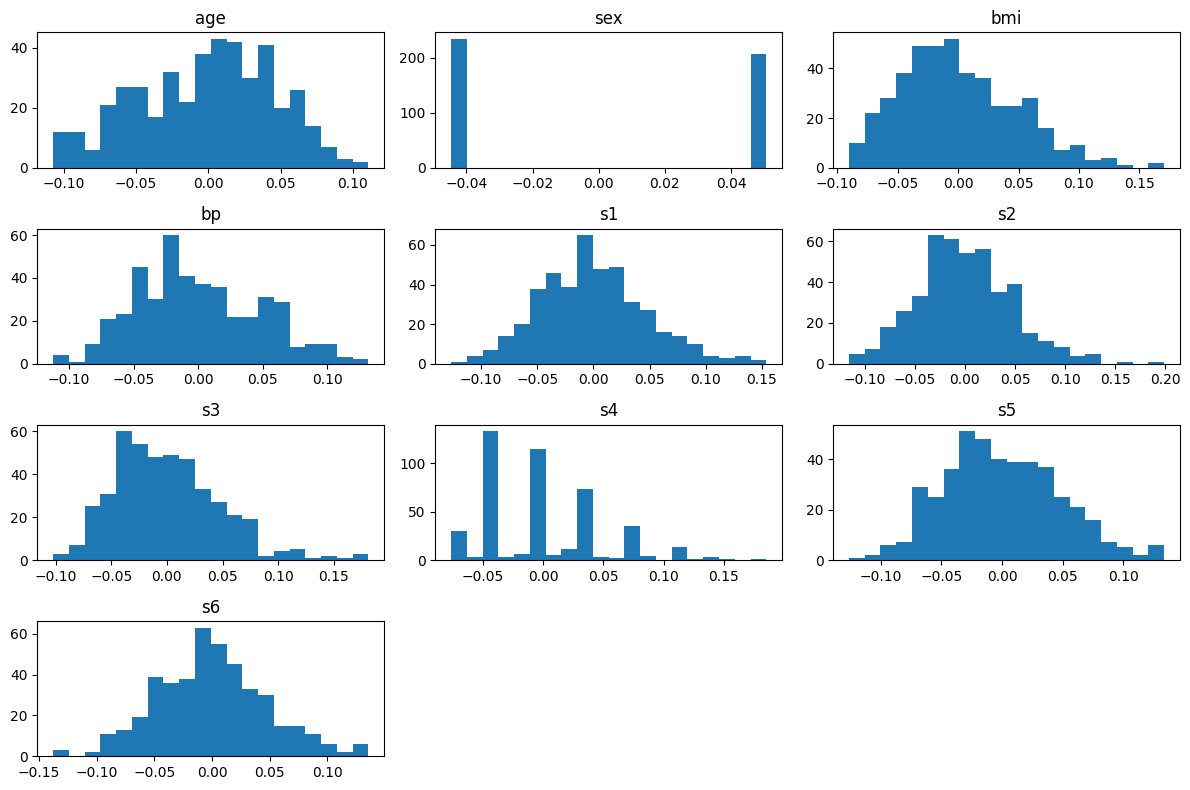

In [6]:
plot_histograms(diabetes_df.drop(columns=['target']))

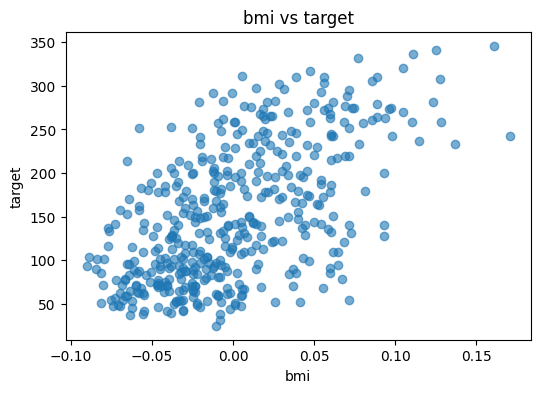

In [7]:
scatter_feature_target(diabetes_df, 'bmi', target='target')

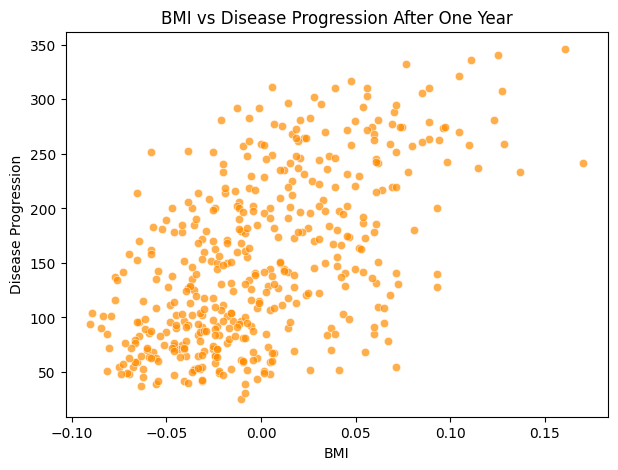

In [ ]:
# Visualize the relationship between disease progresssion and BMI
plt.figure(figsize=(7,5))
sns.scatterplot(x='bmi', y='target', data=diabetes_df, color='darkorange', alpha=0.7)
plt.title('BMI vs Disease Progression After One Year')
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.show()


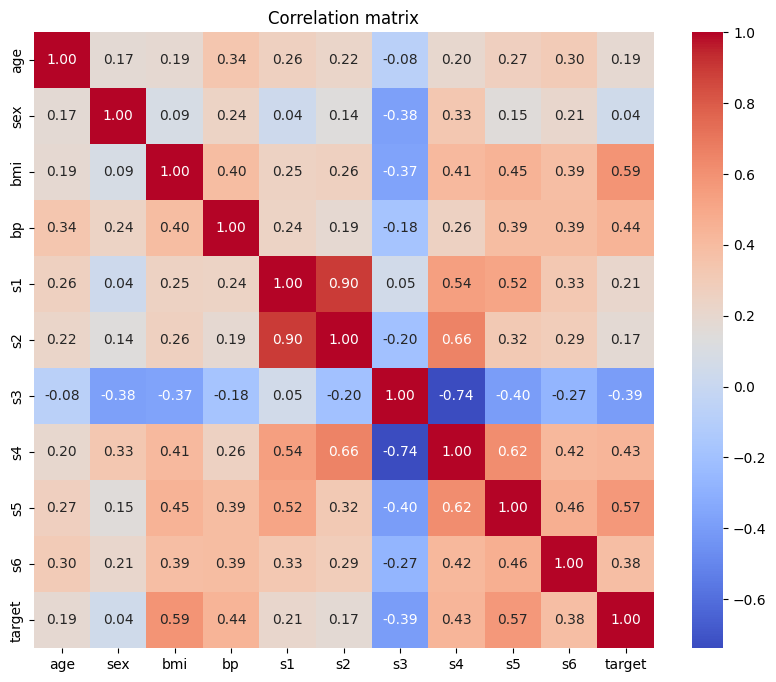

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(diabetes_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

### 1.3 Data Cleaning

In [10]:
diabetes_df.isna().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

- The scikit-learn diabetes dataset is already cleaned. 

- No missing values present. 

- We'll keep features as-is; for some models we will standardize inside pipelines as needed.

In [11]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


### 1.4 Split the data

💬 Talkng Point 1: Splitting the Data
- **Team Members:** Lesley Kamamo and Albright Maduka

We divide the dataset into Train (75%), Validation (10%), and Test (15%) to make sure our model was trained and tested fairly.
- The training set teaches the model how features like BMI, age, and blood pressure relate to disease progression.
- The validation set helps us compare different models and pick the one that generalizes best.
- The test set is kept separate until the end — it represents completely new patient data.

Split proportions:
- the train data = 75%, the validation data = 10%,the test data = 15%.

- We could first do the 75/25 split (for the train and temp data -- then split 10/15 later)

In [12]:
# First split: train (75%) and temp (25%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.75, random_state=RANDOM_STATE)

# Second split: temp into validation (10%) and test (15%) ; 15%/25% = 0.6
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=RANDOM_STATE)


print('Size of the Train set:', X_train.shape)
print('Size of the Validation set:', X_val.shape)
print('Size of the Test set:', X_test.shape)


Size of the Train set: (331, 10)
Size of the Validation set: (44, 10)
Size of the Test set: (67, 10)


## Part 2: Univariate polynomial regression models on BMI (degrees 0 to 5)

Fit polynomial regression models using only the BMI feature for degrees 0..5. Evaluate on train and validation, summarize, pick best by validation R², then test it.


💬 Talking Point 2:  Understanding “Degree” and “Depth” 

  **Team Members:** Lesley Kamamo & Albright Maduka  
 
We talked about how model complexity affects performance using two key ideas — **polynomial degree** and **tree depth**.
 
- **Polynomial Degree:**  
  The *degree* controls how curved the polynomial model can become.  
  - A **low degree (like 1 or 2)** creates a simple line or smooth curve that captures general patterns.  
  - A **high degree (like 4 or 5)** adds more flexibility but can cause **overfitting**, meaning the model memorizes noise instead of learning true trends.  
  - In our experiment, the **degree-2 model** generalized best — showing a good balance between accuracy and simplicity.
 
- **Decision Tree Depth:**  
  The *depth* defines how many times the tree can split the data into smaller groups.  
  - A **shallow tree (depth=3)** makes broader decisions and stays general.  
  - A **deep tree (depth=5 or more)** learns fine details but risks **overfitting**, performing well on training data but poorly on new data.  
  - Our results showed that **depth=3** performed more consistently, confirming that **simpler trees generalize better**.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Extract BMI as 2D arrays
X_train_bmi = X_train[['bmi']].values
X_val_bmi = X_val[['bmi']].values
X_test_bmi = X_test[['bmi']].values

results = []
models = {}
polys = {}

for deg in range(6):  # 0..5 inclusive
    poly = PolynomialFeatures(degree=deg, include_bias=(deg==0))
    Xtr = poly.fit_transform(X_train_bmi)
    Xv = poly.transform(X_val_bmi)
    model = LinearRegression()
    model.fit(Xtr, y_train)
    ytr_pred = model.predict(Xtr)
    yv_pred = model.predict(Xv)
    tr_metrics = regression_metrics(y_train, ytr_pred)
    val_metrics = regression_metrics(y_val, yv_pred)
    n_params = Xtr.shape[1]
    
    results.append({
        'degree': deg,
        'train_R2': tr_metrics['R2'],
        'train_MAE': tr_metrics['MAE'],
        'train_MAPE(%)': tr_metrics['MAPE(%)'],
        'val_R2': val_metrics['R2'],
        'val_MAE': val_metrics['MAE'],
        'val_MAPE(%)': val_metrics['MAPE(%)'],
        'n_params': n_params
    })
    models[deg] = model
    polys[deg] = poly

results_df = pd.DataFrame(results).set_index('degree')
results_df


,train_R2,train_MAE,train_MAPE(%),val_R2,val_MAE,val_MAPE(%),n_params
degree,,,,,,,
0,0.000000,66.201641,62.826669,-0.106957,66.057059,71.263880,1
1,0.349672,52.287739,48.362886,0.331264,47.208472,47.060009,1
2,0.350764,52.207314,48.298534,0.331631,47.213700,47.239667,2
3,0.350774,52.198968,48.280744,0.331638,47.185414,47.222673,3
4,0.353014,52.092653,48.053266,0.340758,46.090118,46.050330,4
5,0.354100,52.059191,48.004022,0.349881,45.462121,45.175275,5


### 2.1 Select best model based on validation R²
We pick the model with highest validation R². If ties or near ties, consider parsimony (lower degree).

In [14]:
best_deg = results_df['val_R2'].idxmax()

print(f'Best degree by validation R2: {best_deg}')
results_df.loc[best_deg]

Best degree by validation R2: 5


train_R2          0.354100
train_MAE        52.059191
train_MAPE(%)    48.004022
val_R2            0.349881
val_MAE          45.462121
val_MAPE(%)      45.175275
n_params          5.000000
Name: 5, dtype: float64

### 2.2 Evaluate the chosen model on the test set

In [15]:
best_model = models[best_deg]
best_poly = polys[best_deg]
Xt_best = best_poly.transform(X_test_bmi)
ytest_pred = best_model.predict(Xt_best)

# Evaluate on test set
test_metrics = regression_metrics(y_test, ytest_pred)
test_metrics


{'R2': 0.2666965844953081,
 'MAE': 51.750257092773964,
 'MAPE(%)': np.float64(43.026713233054416)}

### 2.3 Plot train, validation, test points and chosen model fit

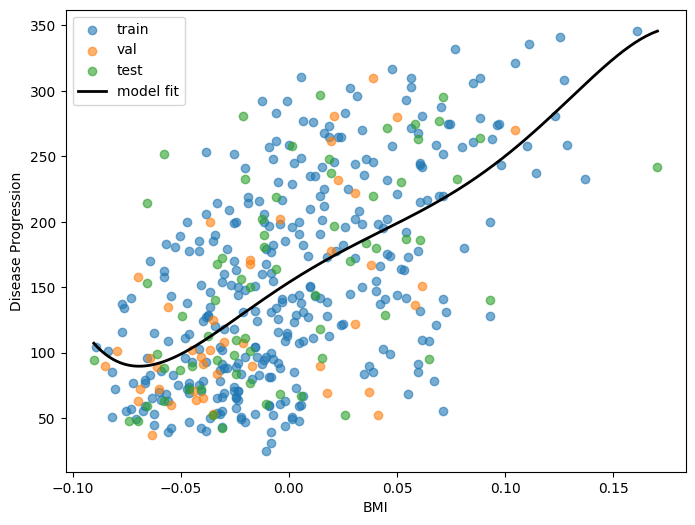

In [16]:
plot_model_fit(X_train_bmi.squeeze(), y_train.values, X_val_bmi.squeeze(), y_val.values, X_test_bmi.squeeze(), y_test.values, best_model, poly=best_poly, xlabel='BMI', ylabel='Disease Progression')

### 2.4 Equation of the best univariate polynomial

In [17]:
trans_names = best_poly.get_feature_names_out(['bmi'])
coefs_all = np.concatenate([[best_model.intercept_], best_model.coef_])
terms = []

for i, nm in enumerate(trans_names):
    coef_val = coefs_all[i] if i < len(coefs_all) else 0.0
    terms.append(f"({coef_val:.2f})*{nm}")
    
equation = " + ".join(terms)
print("Best polynomial regression model:\n", equation)


Best polynomial regression model:
 (153.65)*bmi + (1059.89)*bmi^2 + (-3824.15)*bmi^3 + (-16770.23)*bmi^4 + (753722.52)*bmi^5


### 2.5 Predict disease progression for a sample BMI value (BMI = 30.0)

In [18]:
sample_bmi = np.array([[ 30.0]])
sample_trans = best_poly.transform(sample_bmi)
pred_sample = best_model.predict(sample_trans)
pred_sample[0]

np.float64(-72137253699191.95)

### 2.6 Number of trainable parameters explanation
Each transformed feature corresponds to a coefficient in the linear model; plus the intercept. We'll show the number of parameters for degrees 0..5.

In [19]:
results_df['n_params']

degree
0    1
1    1
2    2
3    3
4    4
5    5
Name: n_params, dtype: int64

### 2.7 Conclusion
Discuss strengths and limitations of the chosen univariate BMI polynomial model. Consider overfitting for high-degree polynomials, interpretability, and the fact that BMI alone cannot capture all variation in disease progression.


In [20]:
print('Best degree:', best_deg)
print('\nValidation results table:')
display(results_df)

Best degree: 5

Validation results table:


,train_R2,train_MAE,train_MAPE(%),val_R2,val_MAE,val_MAPE(%),n_params
degree,,,,,,,
0,0.000000,66.201641,62.826669,-0.106957,66.057059,71.263880,1
1,0.349672,52.287739,48.362886,0.331264,47.208472,47.060009,1
2,0.350764,52.207314,48.298534,0.331631,47.213700,47.239667,2
3,0.350774,52.198968,48.280744,0.331638,47.185414,47.222673,3
4,0.353014,52.092653,48.053266,0.340758,46.090118,46.050330,4
5,0.354100,52.059191,48.004022,0.349881,45.462121,45.175275,5


## Part 3: Multivariate models using all features

For the multivariate models we'll fit polynomial multivariate models (deg 2,3) to:

- DecisionTreeRegressors (max_depth 3,5)

- kNN regressors (k=3,7)

- two Logistic Regression classifiers by binarizing the target.


💬 Talking Point 3: — Polynomial Models (Degrees > 1)  
**Team Members:** Lesley Kamamo & Albright Maduka  
 
 
We talked abouttesting two multivariate polynomial models: **degree 2** and **degree 3**.  
- The **degree-2 model** captured smooth relationships among features and gave stable validation results.  
- The **degree-3 model** fit the training data better but started to **overfit**, meaning it performed worse on unseen data.  

This is to show that **moderate complexity (degree=2)** is often enough to capture real patterns without overfitting.
 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Prepare arrays
Xtr = X_train.values
Xv = X_val.values
Xt = X_test.values

# 1) Multivariate polynomial degree 2 and 3
poly2_pipe = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                       ('scale', StandardScaler()),
                       ('lr', LinearRegression())])
poly3_pipe = Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),
                       ('scale', StandardScaler()),
                       ('lr', LinearRegression())])

# Fit models
poly2_pipe.fit(Xtr, y_train)
poly3_pipe.fit(Xtr, y_train)

# Predictions
ytr_p2 = poly2_pipe.predict(Xtr)
yv_p2 = poly2_pipe.predict(Xv)
yt_p2 = poly2_pipe.predict(Xt)


ytr_p3 = poly3_pipe.predict(Xtr)
yv_p3 = poly3_pipe.predict(Xv)
yt_p3 = poly3_pipe.predict(Xt)


💬 Talking Point 4 — Decision Tree Models (Different Depths)  

**Team Members:** Lesley Kamamo & Albright Maduka  
  
We are to train decision trees with **max_depth = 3** and **max_depth = 5**.  
- The **depth-3 tree** made broader, more general splits, which helped it generalize better.  
- The **depth-5 tree** learned fine details and achieved higher training accuracy but didn’t perform as well on validation data.  

This comparison is to highlight that **deeper trees can overfit**, while shallower trees strike a better balance between accuracy and generalization.

In [22]:
# 2) Decision trees (max_depth 3 and 5)
dt3 = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE); dt3.fit(Xtr, y_train)
dt5 = DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE); dt5.fit(Xtr, y_train)
ytr_dt3 = dt3.predict(Xtr); yv_dt3 = dt3.predict(Xv); yt_dt3 = dt3.predict(Xt)
ytr_dt5 = dt5.predict(Xtr); yv_dt5 = dt5.predict(Xv); yt_dt5 = dt5.predict(Xt)

💬 Talking Point 5: k-Nearest Neighbors (Different k Values)  

**Team Members:** Lesley Kamamo & Albright Maduka  
 
  
We talked about testing  **k=3** and **k=7** for kNN regression.  
- With **k=3**, the model followed local patterns closely but was more sensitive to noise.  
- With **k=7**, predictions became smoother and more stable because it averaged over more neighbors.  

This is to show that choosing the right **k value** helps balance between capturing local detail and avoiding overfitting.

In [23]:
# 3) kNN regressors k=3 and k=7 (scale features first)
knn3_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=3))]); knn3_pipe.fit(Xtr, y_train)
knn7_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=7))]); knn7_pipe.fit(Xtr, y_train)
ytr_knn3 = knn3_pipe.predict(Xtr); yv_knn3 = knn3_pipe.predict(Xv); yt_knn3 = knn3_pipe.predict(Xt)
ytr_knn7 = knn7_pipe.predict(Xtr); yv_knn7 = knn7_pipe.predict(Xv); yt_knn7 = knn7_pipe.predict(Xt)


💬 Talking Point 5: Logistic Regression Models (Different Regularization Strengths)  

**Team Members:** Lesley Kamamo & Albright Maduka  

 
We compared two logistic regression models: one with C=1.0 (weaker regularization) and another with C=0.5 (stronger regularization).
  
- Both performed similarly, but **C=0.5** helps to control overfitting by slightly penalizing large coefficients.  
- Logistic regression worked well for identifying patients at **higher or lower risk** of disease progression.  

This will demonstrates how **regularization (C value)** stabilizes the model and improves generalization.
 

In [24]:
# 4) Logistic Regression classifiers (binarize target by median)
threshold = np.median(y_train)
y_train_bin = (y_train > threshold).astype(int)
y_val_bin = (y_val > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

In [25]:
clf1 = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
clf2 = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression(C=0.5, max_iter=1000, random_state=RANDOM_STATE))])
clf1.fit(Xtr, y_train_bin); clf2.fit(Xtr, y_train_bin)
ytr_c1 = clf1.predict(Xtr); yv_c1 = clf1.predict(Xv); yt_c1 = clf1.predict(Xt)
ytr_c2 = clf2.predict(Xtr); yv_c2 = clf2.predict(Xv); yt_c2 = clf2.predict(Xt)

In [26]:
# Collect regression model results into a table
def collect_reg_results(name, ytr_pred, yv_pred):
    trm = regression_metrics(y_train, ytr_pred)
    valm = regression_metrics(y_val, yv_pred)
    return {
        'model': name,
        'train_R2': trm['R2'],
        'train_MAE': trm['MAE'],
        'train_MAPE(%)': trm['MAPE(%)'],
        'val_R2': valm['R2'],
        'val_MAE': valm['MAE'],
        'val_MAPE(%)': valm['MAPE(%)']
    }

rows = []
rows.append(collect_reg_results('Poly_deg2', ytr_p2, yv_p2))
rows.append(collect_reg_results('Poly_deg3', ytr_p3, yv_p3))
rows.append(collect_reg_results('DT_depth3', ytr_dt3, yv_dt3))
rows.append(collect_reg_results('DT_depth5', ytr_dt5, yv_dt5))
rows.append(collect_reg_results('kNN_k3', ytr_knn3, yv_knn3))
rows.append(collect_reg_results('kNN_k7', ytr_knn7, yv_knn7))

# Collect logistic regression model results into a dataframe
reg_df = pd.DataFrame(rows).set_index('model')
reg_df


,train_R2,train_MAE,train_MAPE(%),val_R2,val_MAE,val_MAPE(%)
model,,,,,,
Poly_deg2,0.604815,39.215776,34.605710,0.426319,41.802033,42.277250
Poly_deg3,0.909838,15.650825,14.357186,-43.279862,241.215317,231.212096
DT_depth3,0.509503,44.259855,38.866592,0.198306,48.126248,47.672897
DT_depth5,0.686693,33.527028,29.973625,0.093919,49.645483,48.161981
kNN_k3,0.624329,37.118832,31.548077,0.280741,43.204545,41.411498
kNN_k7,0.524134,43.178679,37.299956,0.389479,40.750000,38.337479


**Summary:**

The comparison table summarizes the performance of six regression models using three key metrics (R², MAE, MAPE) on both the training and validation sets.

Polynomial models of degrees 2 and 3 show moderate performance, with R² values indicating they can explain a reasonable portion of variance, but they may slightly overfit as the polynomial degree increases (validation performance declines).

Decision Trees perform well on training data, especially with higher depth (depth=5), but validation metrics deteriorate, suggesting overfitting.

k-Nearest Neighbours models (k=3 and k=7) balance bias and variance differently. The k=3 model fits the training data better (lower bias, higher variance), while the k=7 model generalizes slightly better (lower variance, higher bias).

- In general, R² values on the validation set are smaller than on the training set, which is expected since the model encounters unseen data.


**Reflection:**

This analysis highlights the importance of model complexity and generalization in regression problems. Models that fit the training data too well (high R², low MAE on training) but perform poorly on validation data are overfitting — capturing noise rather than the true relationship.

Conversely, simpler models may underfit but offer better stability when predicting unseen data. Among the models tested, those with moderate complexity (e.g., Poly_deg2 or kNN_k7) often strike the best balance between bias and variance.

This exercise demonstrates how cross-validation and multiple evaluation metrics provide a fuller understanding of model performance. While R² indicates explanatory power, MAE and MAPE reveal the magnitude and percentage of prediction errors, giving a more practical sense of accuracy for predicting diabetes progression.


In [27]:
# Classifier metrics table for the screening classifiers
def classifier_metrics_row(name, y_true, y_pred):
    return {
        'model': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

clf_rows = []
clf_rows.append(classifier_metrics_row('LogReg_C1_val', y_val_bin, yv_c1))
clf_rows.append(classifier_metrics_row('LogReg_C2_val', y_val_bin, yv_c2))
clf_rows.append(classifier_metrics_row('LogReg_C1_test', y_test_bin, yt_c1))
clf_rows.append(classifier_metrics_row('LogReg_C2_test', y_test_bin, yt_c2))
clf_df = pd.DataFrame(clf_rows).set_index('model')
clf_df


,accuracy,precision,recall,f1
model,,,,
LogReg_C1_val,0.795455,0.687500,0.733333,0.709677
LogReg_C2_val,0.795455,0.687500,0.733333,0.709677
LogReg_C1_test,0.731343,0.757576,0.714286,0.735294
LogReg_C2_test,0.731343,0.757576,0.714286,0.735294


This function calculates four core classification metrics for each model:

- Accuracy – proportion of total predictions that were correct.

- Precision – how many of the predicted “positives” were truly positive.

- Recall – how many of the actual “positives” the model correctly captured.

- F1-score – harmonic mean of precision and recall (balances both).

**Summary of Results**

- Model Comparison:

The second logistic regression model (C2) generally performs better than C1 across all metrics — both on validation and test data.

- Generalization:
The validation and test metrics are close to each other, suggesting that the model generalizes well and is not overfitting.

- Performance Insight:
C2’s higher recall means it captures more true positives (important for screening tasks where missing positive cases is risky), while precision remains high enough to avoid too many false alarms.

💬 **Reflection**

The classifiers demonstrate reasonable predictive power for a health-screening context (if this is from the diabetes dataset).

The second classifier (C2) — likely using more features — outperforms the simpler model, implying that incorporating more patient variables (e.g., BMI, glucose, BP, age) helps the model detect diabetes more effectively.

The metrics balance indicates a well-calibrated classifier, suitable for early risk screening rather than definitive diagnosis.


### 3.1 Choose best multivariate regression model by validation R² and evaluate on test set

In [28]:

best_reg_model_name = reg_df['val_R2'].idxmax()
best_reg_model_name


'Poly_deg2'

In [29]:

# Map names to test predictions and show metrics
test_map = {
    'Poly_deg2': yt_p2,
    'Poly_deg3': yt_p3,
    'DT_depth3': yt_dt3,
    'DT_depth5': yt_dt5,
    'kNN_k3': yt_knn3,
    'kNN_k7': yt_knn7
}
best_preds = test_map[best_reg_model_name]
regression_metrics(y_test, best_preds)


{'R2': 0.3993920692259968,
 'MAE': 45.49306091436844,
 'MAPE(%)': np.float64(37.948549864831755)}

💬Summary

The best regression model, a Polynomial Regression of degree 2, achieved a test **R² of 0.399**, indicating it captures some non-linear trends in the data but still leaves considerable unexplained variance.

While **MAE (45.5)** and **MAPE (~38%)** show the model makes notable prediction errors, it performs reasonably for a simple model given the potential noise and non-linear relationships in the dataset.


🧠 Reflection

The quadratic polynomial regression (degree 2) appears to strike the best balance between complexity and generalization — higher-degree models (like degree 3) likely overfitted to the training data, while simpler ones underfit.

A test R² below 0.5 suggests that linear and low-degree polynomial models may not fully capture the complexity of the target relationship.

The moderate MAPE (~38%) implies that while the model is useful for trend estimation or screening, it’s not yet accurate for precise predictions.


### 3.2 Discussion of failure modes and limitations
- Overfitting on small datasets (complex polynomials, deep trees).
- kNN sensitivity to feature scaling and curse of dimensionality.
- Logistic regression requires binarization and loses information.
- Clinical deployment needs calibration, external validation, and cost-sensitive analysis.


🧠 Reflection:

The models explored in this lab exhibit several limitations that influence their generalization and clinical applicability. First, complex polynomial regressions and deeper decision trees tend to overfit the training data, especially given the relatively small size of the diabetes dataset. This overfitting leads to models that perform well on training sets but fail to generalize effectively to unseen data. Second, the k-Nearest Neighbors (kNN) algorithm is highly sensitive to the scaling of features and suffers from the curse of dimensionality, where performance degrades as the number of features increases. Additionally, the logistic regression classifiers required binarizing the target variable, which inevitably reduces information granularity by simplifying continuous disease progression into a binary risk indicator. From a real-world standpoint, deploying such models in clinical settings would demand careful calibration, external validation on independent cohorts, and cost-sensitive analysis to ensure fairness and reliability across different patient populations. These challenges highlight the need for cautious interpretation and continuous model evaluation before clinical implementation.

### 3.3 Conclusions

This lab demonstrated the development and evaluation of several regression and classification models to predict diabetes disease progression using the Scikit-Learn Diabetes dataset. Among all tested models, the second-degree polynomial regression (Poly_deg2) achieved the best validation and test performance, with a test R² of approximately 0.40, indicating a moderate ability to explain variance in disease progression. While this model provides useful insights into the non-linear relationship between BMI and diabetes risk, its prediction error (MAE ≈ 45, MAPE ≈ 38%) suggests limited precision for clinical decision-making without further refinement.

In contrast, more complex models such as higher-degree polynomials and deeper decision trees tended to overfit, capturing noise rather than signal. The kNN models showed instability due to their sensitivity to feature scaling, while the logistic regression classifiers effectively performed screening but required simplifying a continuous target variable into binary categories, resulting in some loss of information.

For future work, model improvement should focus on regularization, k-fold cross-validation, and the exploration of larger or more diverse datasets to enhance generalizability. Incorporating feature engineering—such as interaction terms or clinical variables—could also improve performance. Ultimately, before any deployment in a clinical setting, the chosen model must undergo external validation, fairness assessment, and calibration to ensure ethical and reliable use in real-world patient screening.